In [1]:
import glob
import numpy as np
import pandas as pd

from skelo.model.elo import EloEstimator

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
infiles = pd.Series(glob.glob('/home/daniel/wizepair2/notebooks/elo/elo-*.csv.gz')).sample(frac=0.2, replace=True)
df = pd.concat(infiles.parallel_apply(pd.read_csv, compression='gzip').tolist())

In [4]:
df.publication_date_greatest = pd.to_datetime(df.publication_date_greatest)
df.sort_values('publication_date_greatest', inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
df['label'] = df.standard_change=='increase'

In [6]:
df.head(3)

,mmp_delta_uuid,assay_id,standard_type,standard_change,publication_date_greatest,fragment1,fragment2,radius,pref_name,chessleague_uuid,rand_partition,label
0,678c3d63fe7cb47fed87819f51629f61,688499,Potency,no-change,1970-01-01,7c60d053306f1d4ef2f1f37662d04c20,0cbfe85da56d71085e6beb9fabca3a38,3,Signal transducer and activator of transcripti...,be64f385ec167e0fccb4a6237826b894,561,False
1,211df80d08beafc30ef66d2b28117722,688158,EC50,increase,1970-01-01,7e10e1c20012e772c8eb6e85da3d069f,2ea4a470936415942df61536cd28de10,3,Unchecked,10319a02c7b211608c22c613eb911008,952,True
2,c0a5f4bb872aa0e14e14486305e3cd7a,737531,EC50,increase,1970-01-01,64bf3f0ea987276b8e996923e0ee9dde,85e8762f0c9d39954c1310ccadbdc290,3,Unchecked,10319a02c7b211608c22c613eb911008,952,True


In [7]:
df.publication_date_greatest.quantile([0, 0.05, 0.5, 0.95, 1])

0.00   1970-01-01
0.05   1991-05-02
0.50   2010-01-04
0.95   2019-02-22
1.00   2021-01-01
Name: publication_date_greatest, dtype: datetime64[ns]

In [8]:
len(df.index)

23163633

In [9]:
from sklearn.model_selection import GridSearchCV

def elo_grid(df, return_ratings=False):
    
    # create a table where winner / loser is defined
    df = df.copy(deep=True).reset_index()
    if df.empty: return None

    model = EloEstimator(
            key1_field="fragment1",
            key2_field="fragment2",
            timestamp_field="publication_date_greatest",
            initial_time=pd.to_datetime('1970-01-01')
    )

    clf = GridSearchCV(
        model,
        param_grid={'default_k': [5, 10, 20, 40, 80, 160, 320]},
        refit=False,
        cv=[(df.index, df.index)],
        scoring='accuracy'
    ).fit(df, df['label'])

    return pd.DataFrame(clf.cv_results_)

In [10]:
df_elo_grid = df.groupby(['chessleague_uuid']).parallel_apply(elo_grid)

In [11]:
df_elo_grid.groupby('param_default_k').median()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,mean_test_score,std_test_score,rank_test_score
param_default_k,,,,,,,,
5,0.001919,0.0,0.003029,0.0,0.517986,0.517986,0.0,1.0
10,0.001675,0.0,0.003013,0.0,0.517949,0.517949,0.0,1.0
20,0.001668,0.0,0.003005,0.0,0.517941,0.517941,0.0,1.0
40,0.001668,0.0,0.003008,0.0,0.518072,0.518072,0.0,1.0
80,0.001669,0.0,0.003001,0.0,0.518169,0.518169,0.0,1.0
160,0.001668,0.0,0.003006,0.0,0.517947,0.517947,0.0,1.0
320,0.001668,0.0,0.003007,0.0,0.517795,0.517795,0.0,1.0


In [12]:
def elo(df, return_ratings=False):
    
    # create a table where winner / loser is defined
    if df.empty: return None
    
    # fit model
    model = EloEstimator(
        key1_field="fragment1",
        key2_field="fragment2",
        timestamp_field="publication_date_greatest",
        initial_time=pd.to_datetime('1970-01-01'),
        default_k=10
    ).fit(df, df.label)
    if return_ratings: return model.rating_model.to_frame()

    # calculate proba
    df['proba'] = model.transform(df, output_type='prob', strict_past_data=True)
    return df[['assay_id', 'mmp_delta_uuid', 'chessleague_uuid', 'proba', 'label']]
    

In [13]:
df_elo = df.groupby(['chessleague_uuid']).parallel_apply(elo)

In [14]:
df_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    0.000001
0.1    0.478253
0.5    0.500000
0.9    0.522516
1.0    0.999999
Name: proba, dtype: float64

In [15]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_elo.label, df_elo.proba)

0.5490712246870644

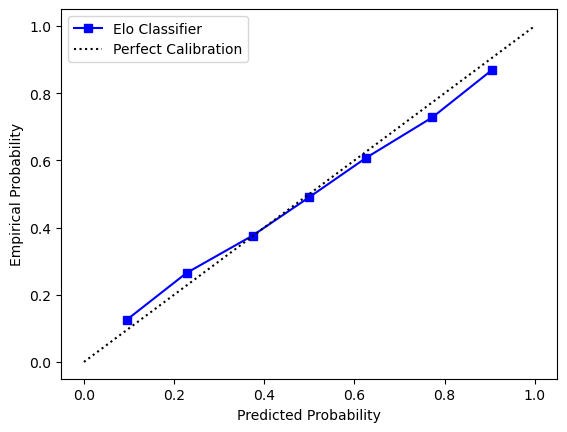

In [16]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_elo.label,
  df_elo.proba,
  n_bins=7
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [17]:
df_elo.sort_values('proba', ascending=False)

assay_id  \
chessleague_uuid                                      
7f2737dddb558e0912a66198bf7f00d6 23158659   1993483   
                                 19888829   1551389   
                                 16960591   1285834   
                                 16959346   1285833   
                                 16960355   1285832   
...                                             ...   
                                 19844840   1579651   
                                 19887526   1551388   
                                 21556393   1826296   
                                 21888667   1812209   
                                 21890170   1812209   

                                                             mmp_delta_uuid  \
chessleague_uuid                                                              
7f2737dddb558e0912a66198bf7f00d6 23158659  7444479bff3cfe94bb79f835be8f6482   
                                 19888829  451373a8230cce0c5ff8a549df98facf   
                                 16960591  6c99a6afbedb5fd684cde8f2c2152f9f   
                                 16959346  0ea030524429f82a3014db7d0e79fb66   
                                 16960355  4fbfe5da14c7c4f0a021a0ba0f8f76f9   
...                                                                     ...   
                                 19844840  343612be8fa0b504b0cc39145e0d3d77   
                                 19887526  3120ea60d3af007fb1583f24706d4fa9   
                                 21556393  bccf4f93f0bc6fb1862f264eabb9e039   
                                 21888667  99a7594ca21b3fed16c543467954be2e   
                                 21890170  99a7594ca21b3fed16c543467954be2e   

                                                           chessleague_uuid  \
chessleague_uuid                                                              
7f2737dddb558e0912a66198bf7f00d6 23158659  7f2737dddb558e0912a66198bf7f00d6   
                                 19888829  7f2737dddb558e0912a66198bf7f00d6   
                                 16960591  7f2737dddb558e0912a66198bf7f00d6   
                                 16959346  7f2737dddb558e0912a66198bf7f00d6   
                                 16960355  7f2737dddb558e0912a66198bf7f00d6   
...                                                                     ...   
                                 19844840  7f2737dddb558e0912a66198bf7f00d6   
                                 19887526  7f2737dddb558e0912a66198bf7f00d6   
                                 21556393  7f2737dddb558e0912a66198bf7f00d6   
                                 21888667  7f2737dddb558e0912a66198bf7f00d6   
                                 21890170  7f2737dddb558e0912a66198bf7f00d6   

                                              proba  label  
chessleague_uuid                                            
7f2737dddb558e0912a66198bf7f00d6 23158659  0.999999  False  
                                 19888829  0.999919  False  
                                 16960591  0.998670  False  
                                 16959346  0.998670   True  
                                 16960355  0.998670  False  
...                                             ...    ...  
                                 19844840  0.000089  False  
                                 19887526  0.000081   True  
                                 21556393  0.000003  False  
                                 21888667  0.000001   True  
                                 21890170  0.000001   True  

[23163633 rows x 5 columns]

In [18]:
df_ratings = df.groupby(['chessleague_uuid']).parallel_apply(elo, return_ratings=True)

In [19]:
df_ratings.sort_values('rating', ascending=False)

key  \
chessleague_uuid                                                            
bbe2b268137e37fa524bb8820172f4df 99448   5b4a3554855bc14716c32b29474cc50c   
                                 99447   5b4a3554855bc14716c32b29474cc50c   
                                 99446   5b4a3554855bc14716c32b29474cc50c   
                                 99445   5b4a3554855bc14716c32b29474cc50c   
                                 99444   5b4a3554855bc14716c32b29474cc50c   
...                                                                   ...   
7f2737dddb558e0912a66198bf7f00d6 874185  369fe85e1781430d072ca992d9a65f8a   
                                 874187  369fe85e1781430d072ca992d9a65f8a   
                                 874184  369fe85e1781430d072ca992d9a65f8a   
                                 874189  369fe85e1781430d072ca992d9a65f8a   
                                 874186  369fe85e1781430d072ca992d9a65f8a   

                                              rating valid_from   valid_to  
chessleague_uuid                                                            
bbe2b268137e37fa524bb8820172f4df 99448   2137.154359 2020-01-01 2020-01-01  
                                 99447   2136.950956 2020-01-01 2020-01-01  
                                 99446   2136.747084 2020-01-01 2020-01-01  
                                 99445   2136.542743 2020-01-01 2020-01-01  
                                 99444   2136.337929 2020-01-01 2020-01-01  
...                                              ...        ...        ...  
7f2737dddb558e0912a66198bf7f00d6 874185  -996.752427 2020-10-12        NaT  
                                 874187  -996.752433 2020-11-17 2020-11-19  
                                 874184 -1001.752427 2020-10-12 2020-10-12  
                                 874189 -1001.752433 2020-11-19        NaT  
                                 874186 -1006.752427 2020-10-12 2020-11-17  

[55811984 rows x 4 columns]

In [20]:
df_ratings[df_ratings.valid_to.isna()].to_csv('/home/daniel/wizepair2/elo_ratings.csv.gz', compression='gzip')